<a href="https://colab.research.google.com/github/aayushkumarjvs/ConditionalNeuralProcess-Implementation/blob/master/CNP_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections

In [0]:
# The CNP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tesor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.4,
               sigma_scale=1.0,
               testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """
    num_total_points = tf.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = tf.reduce_sum(
        norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
    """
    num_context = tf.random_uniform(
        shape=[], minval=3, maxval=self._max_num_context, dtype=tf.int32)

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      x_values = tf.tile(
          tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
          [self._batch_size, 1])
      x_values = tf.expand_dims(x_values, axis=-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
      num_target = tf.random_uniform(
          shape=(), minval=2, maxval=self._max_num_context, dtype=tf.int32)
      num_total_points = num_context + num_target
      x_values = tf.random_uniform(
          [self._batch_size, num_total_points, self._x_size], -2, 2)

    # Set kernel parameters
    l1 = (
        tf.ones(shape=[self._batch_size, self._y_size, self._x_size]) *
        self._l1_scale)
    sigma_f = tf.ones(
        shape=[self._batch_size, self._y_size]) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.matmul(
        cholesky,
        tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations
      idx = tf.random_shuffle(tf.range(num_target))
      context_x = tf.gather(x_values, idx[:num_context], axis=1)
      context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return CNPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=tf.shape(target_x)[1],
        num_context_points=num_context)

CNP Encoder

In [0]:
class DeterministicEncoder(object):
  """The Encoder."""

  def __init__(self, output_sizes):
    """CNP encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
    """
    self._output_sizes = output_sizes

  def __call__(self, context_x, context_y, num_context_points):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of size bs x observations x m_ch. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of size bs x observations x d_ch. For this 1D regression
          task this corresponds to the y-values.
      num_context_points: A tensor containing a single scalar that indicates the
          number of context_points provided in this iteration.

    Returns:
      representation: The encoded representation averaged over all context 
          points.
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = encoder_input.shape.as_list()
    hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Encoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_context_points, size))

    # Aggregator: take the mean over all points
    representation = tf.reduce_mean(hidden, axis=1)

    return representation

CNP Decoder

In [0]:
class DeterministicDecoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """CNP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x, num_total_points):
    """Decodes the individual targets.

    Args:
      representation: The encoded representation of the context
      target_x: The x locations for the target query
      num_total_points: The number of target points.

    Returns:
      dist: A multivariate Gaussian over the target points.
      mu: The mean of the multivariate Gaussian.
      sigma: The standard deviation of the multivariate Gaussian.
    """

    # Concatenate the representation and the target_x
    representation = tf.tile(
        tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
    input = tf.concat([representation, target_x], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = input.shape.as_list()
    hidden = tf.reshape(input, (batch_size * num_total_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Decoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

CNP Model Architecture

In [0]:
class DeterministicModel(object):
  """The CNP model."""

  def __init__(self, encoder_output_sizes, decoder_output_sizes):
    """Initialises the model.

    Args:
      encoder_output_sizes: An iterable containing the sizes of hidden layers of
          the encoder. The last one is the size of the representation r.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to the dimension of
          the y * 2 (it encodes both mean and variance concatenated)
    """
    self._encoder = DeterministicEncoder(encoder_output_sizes)
    self._decoder = DeterministicDecoder(decoder_output_sizes)

  def __call__(self, query, num_total_points, num_contexts, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Array of shape batch_size x num_context x 1 contains the 
              x values of the context points.
          context_y: Array of shape batch_size x num_context x 1 contains the 
              y values of the context points.
          target_x: Array of shape batch_size x num_target x 1 contains the
              x values of the target points.
      target_y: The ground truth y values of the target y. An array of 
          shape batchsize x num_targets x 1.
      num_total_points: Number of target points.

    Returns:
      log_p: The log_probability of the target_y given the predicted
      distribution.
      mu: The mean of the predicted distribution.
      sigma: The variance of the predicted distribution.
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    representation = self._encoder(context_x, context_y, num_contexts)
    dist, mu, sigma = self._decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None
    if target_y is not None:
      log_p = dist.log_prob(target_y)
    else:
      log_p = None

    return log_p, mu, sigma

Plotting the model and it's mean and variance values

In [0]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - var[0, :, 0],
      pred_y[0, :, 0] + var[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()
  ax.set_axis_bgcolor('white')
  plt.show()

In [0]:
"""Running the Conditional Neural Process Model - Training"""
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)
tf.reset_default_graph()

In [0]:
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

In [0]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

# Define the loss
log_prob, _, _ = model(data_train.query, data_train.num_total_points,
                       data_train.num_context_points, data_train.target_y)
loss = -tf.reduce_mean(log_prob)

# Get the predicted mean and variance at the target points for the testing set
_, mu, sigma = model(data_test.query, data_test.num_total_points,
                     data_test.num_context_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

Iteration: 0, loss: 1.5410534143447876


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


AttributeError: ignored

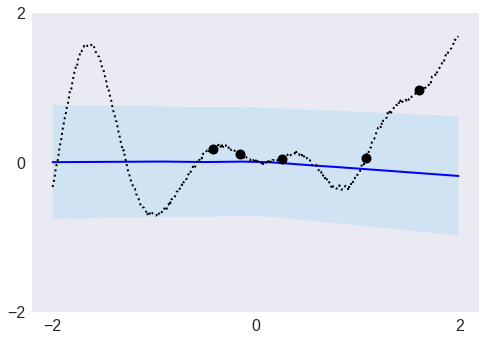

In [24]:
with tf.Session() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, var, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      plot_functions(target_x, target_y, context_x, context_y, pred_y, var)